# temporalpdf V2 Complete Showcase

This notebook demonstrates the complete V2 API pipeline:

1. **Discovery**: Find the best distribution for your data
2. **Temporal Modeling**: Track how distribution parameters evolve
3. **Projection**: Forecast parameters with uncertainty
4. **Decision**: VaR, CVaR, Kelly with confidence intervals
5. **Backtest**: Validate with statistical tests

---

## The Core Concept

**Pipeline 1** (what everyone else does):
```
Data → Model → Y (point prediction)
```

**Pipeline 2** (what temporalpdf enables):
```
Data → Model → Distribution Parameters (μ, σ, ν, ...) → Distribution → Y + uncertainty
```

The model predicts distribution parameters. The distribution gives you:
- Point prediction (mean/median)
- Standard deviation
- Quantiles (any percentile you want)
- Risk metrics (VaR, CVaR, Kelly)
- Full shape (skewness, kurtosis)

In [1]:
import sys
sys.path.insert(0, 'src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import temporalpdf as tpdf

# Set random seed for reproducibility
np.random.seed(42)

# Style settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

print(f'temporalpdf loaded with {len([x for x in dir(tpdf) if not x.startswith("_")])} exports')

temporalpdf loaded with 120 exports


## 1. Load Data

We use S&P 500 daily returns (2010-2024).

In [2]:
# Load S&P 500 returns
df = pd.read_csv('data/equity_returns.csv', parse_dates=['date'])
returns = df['return_pct'].values
dates = df['date'].values

print(f'S&P 500: {len(returns):,} daily returns')
print(f'Date range: {df["date"].min().strftime("%Y-%m-%d")} to {df["date"].max().strftime("%Y-%m-%d")}')
print(f'\nStatistics:')
print(f'  Mean:     {np.mean(returns):+.3f}%')
print(f'  Std:      {np.std(returns):.3f}%')
print(f'  Skewness: {stats.skew(returns):.3f}')
print(f'  Kurtosis: {stats.kurtosis(returns):.3f}')
print(f'  Min:      {np.min(returns):.2f}%')
print(f'  Max:      {np.max(returns):.2f}%')

# Train/test split
split_idx = int(len(returns) * 0.8)
train_returns = returns[:split_idx]
test_returns = returns[split_idx:]
print(f'\nTrain: {len(train_returns):,} days, Test: {len(test_returns):,} days')

S&P 500: 3,772 daily returns
Date range: 2010-01-05 to 2024-12-30

Statistics:
  Mean:     +0.050%
  Std:      1.086%
  Skewness: -0.491
  Kurtosis: 12.243
  Min:      -11.98%
  Max:      9.38%

Train: 3,017 days, Test: 755 days


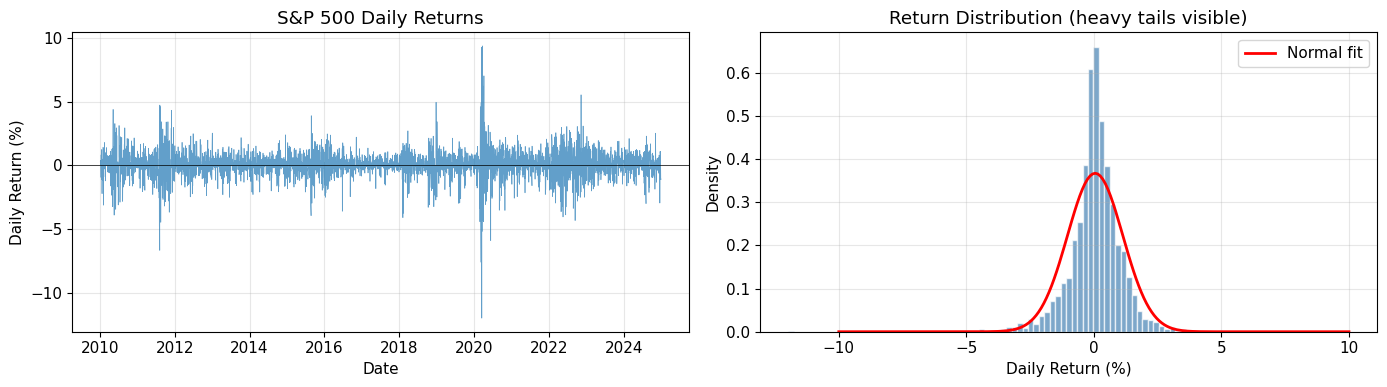

In [3]:
# Quick visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
ax.plot(df['date'], returns, alpha=0.7, lw=0.5)
ax.axhline(0, color='black', ls='-', lw=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return (%)')
ax.set_title('S&P 500 Daily Returns')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.hist(returns, bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='white')
x = np.linspace(-10, 10, 200)
ax.plot(x, stats.norm.pdf(x, np.mean(returns), np.std(returns)), 'r-', lw=2, label='Normal fit')
ax.set_xlabel('Daily Return (%)')
ax.set_ylabel('Density')
ax.set_title('Return Distribution (heavy tails visible)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 2. Discovery: Which Distribution Fits Best?

The `discover()` function compares distributions using cross-validated CRPS (Continuous Ranked Probability Score) and provides statistical significance testing.

In [4]:
# Discover best distribution using cross-validation
discovery = tpdf.discover(
    train_returns,
    candidates=['normal', 'student_t', 'nig'],
    cv_folds=5,
)

print('=' * 60)
print('DISTRIBUTION DISCOVERY RESULTS')
print('=' * 60)
print(f'\nBest distribution: {discovery.best}')
print(f'Confidence: {discovery.confidence}')
print(f'\nCRPS Scores (lower is better):')
for dist, score in discovery.scores.items():
    std = discovery.std_scores.get(dist, 0)
    marker = ' <-- BEST' if dist == discovery.best else ''
    print(f'  {dist:12s}: {score:.4f} ± {std:.4f}{marker}')

print(f'\nPairwise p-values (vs best):')
for pair, pval in discovery.pairwise_pvalues.items():
    sig = '*' if pval < 0.05 else ''
    print(f'  {pair}: {pval:.4f}{sig}')

DISTRIBUTION DISCOVERY RESULTS

Best distribution: student_t
Confidence: low

CRPS Scores (lower is better):
  normal      : 0.5480 ± 0.1104
  student_t   : 0.5329 ± 0.1249 <-- BEST
  nig         : 0.5351 ± 0.1203

Pairwise p-values (vs best):
  ('student_t', 'normal'): 0.1160
  ('student_t', 'nig'): 0.4222


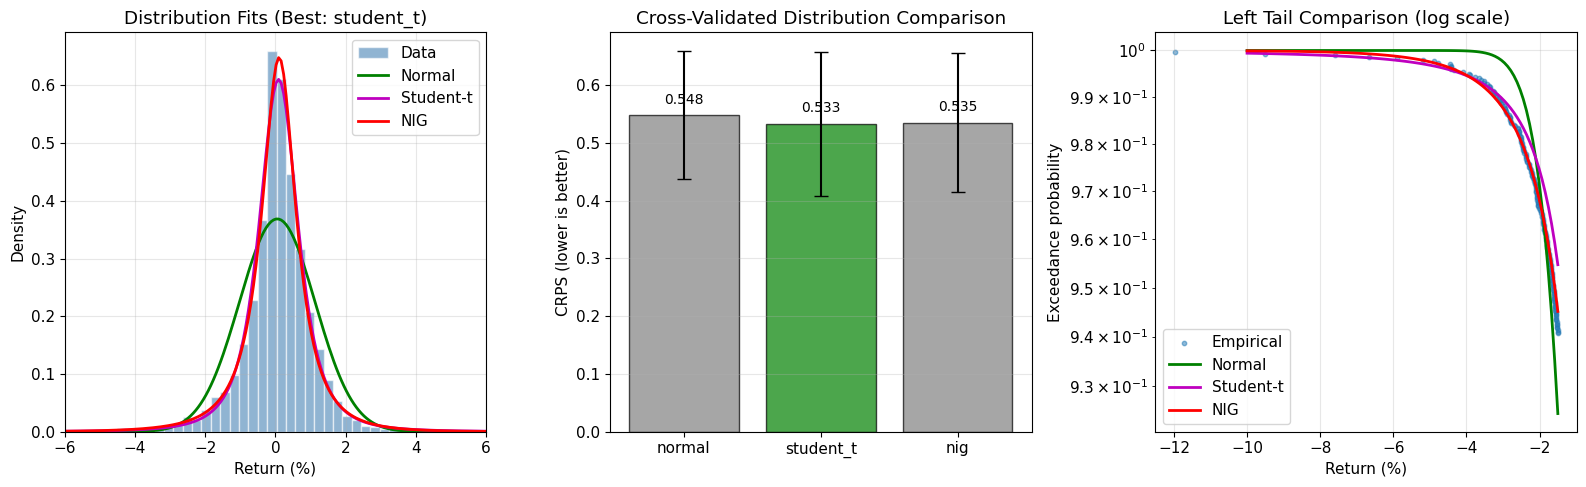

In [5]:
# Visualize the discovery results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Histogram with fitted PDFs
ax = axes[0]
ax.hist(train_returns, bins=80, density=True, alpha=0.6, color='steelblue', edgecolor='white', label='Data')
x = np.linspace(train_returns.min(), train_returns.max(), 300)

# Normal fit
norm_params = tpdf.fit_normal(train_returns)
ax.plot(x, stats.norm.pdf(x, norm_params.mu_0, norm_params.sigma_0), 'g-', lw=2, label='Normal')

# Student-t fit
t_params = tpdf.fit_student_t(train_returns)
ax.plot(x, stats.t.pdf(x, t_params.nu, t_params.mu_0, t_params.sigma_0), 'm-', lw=2, label='Student-t')

# NIG fit
nig = tpdf.NIG()
nig_params = tpdf.fit_nig(train_returns)
ax.plot(x, [nig.pdf(xi, 0.0, nig_params) for xi in x], 'r-', lw=2, label='NIG')

ax.set_xlabel('Return (%)')
ax.set_ylabel('Density')
ax.set_title(f'Distribution Fits (Best: {discovery.best})')
ax.legend()
ax.set_xlim(-6, 6)
ax.grid(True, alpha=0.3)

# Panel 2: CRPS scores bar chart
ax = axes[1]
dists = list(discovery.scores.keys())
scores = [discovery.scores[d] for d in dists]
stds = [discovery.std_scores.get(d, 0) for d in dists]
colors = ['green' if d == discovery.best else 'gray' for d in dists]
bars = ax.bar(dists, scores, yerr=stds, color=colors, alpha=0.7, capsize=5, edgecolor='black')
ax.set_ylabel('CRPS (lower is better)')
ax.set_title('Cross-Validated Distribution Comparison')
for i, (d, s) in enumerate(zip(dists, scores)):
    ax.text(i, s + 0.02, f'{s:.3f}', ha='center', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel 3: Tail comparison (log scale)
ax = axes[2]
sorted_ret = np.sort(train_returns)
n = len(sorted_ret)
empirical_cdf = np.arange(1, n+1) / n

# Plot left tail (1 - CDF in log scale)
left_tail_idx = sorted_ret < -1.5
ax.scatter(sorted_ret[left_tail_idx], 1 - empirical_cdf[left_tail_idx], 
           s=10, alpha=0.5, label='Empirical')

x_tail = np.linspace(-10, -1.5, 100)
ax.plot(x_tail, 1 - stats.norm.cdf(x_tail, norm_params.mu_0, norm_params.sigma_0), 
        'g-', lw=2, label='Normal')
ax.plot(x_tail, 1 - stats.t.cdf(x_tail, t_params.nu, t_params.mu_0, t_params.sigma_0), 
        'm-', lw=2, label='Student-t')
ax.plot(x_tail, [1 - nig.cdf(xi, 0.0, nig_params) for xi in x_tail], 
        'r-', lw=2, label='NIG')

ax.set_yscale('log')
ax.set_xlabel('Return (%)')
ax.set_ylabel('Exceedance probability')
ax.set_title('Left Tail Comparison (log scale)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_discovery.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## 3. Temporal Modeling: How Do Parameters Evolve?

The `TemporalModel` class combines:
- **ParameterTracker**: Rolling window estimation
- **Weighting**: EMA, PowerDecay, etc. for recent-data emphasis
- **Dynamics**: Mean-reverting, random walk, GARCH for parameter evolution

In [6]:
# Create and fit a TemporalModel
model = tpdf.TemporalModel(
    distribution='nig',
    tracking=tpdf.ParameterTracker(
        distribution='nig',
        window=60,    # 60-day rolling windows
        step=5,       # Step every 5 days
    ),
    weighting=tpdf.EMA(halflife=20),  # Recent data matters more
    dynamics={
        'delta': tpdf.MeanReverting(),  # Volatility mean-reverts
        'mu': tpdf.Constant(),          # Mean stays constant
    }
)

# Fit to training data
model.fit(train_returns)

print('=' * 60)
print('TEMPORAL MODEL FITTED')
print('=' * 60)
print(f'\nCurrent NIG Parameters:')
print(f'  mu (location):    {model.current_params.mu:.4f}')
print(f'  delta (scale):    {model.current_params.delta:.4f}')
print(f'  alpha (shape):    {model.current_params.alpha:.4f}')
print(f'  beta (asymmetry): {model.current_params.beta:.4f}')
print(f'\nParameter history: {len(model.param_history)} windows tracked')

TEMPORAL MODEL FITTED

Current NIG Parameters:
  mu (location):    0.1169
  delta (scale):    0.6228
  alpha (shape):    0.5608
  beta (asymmetry): -0.0566

Parameter history: 592 windows tracked


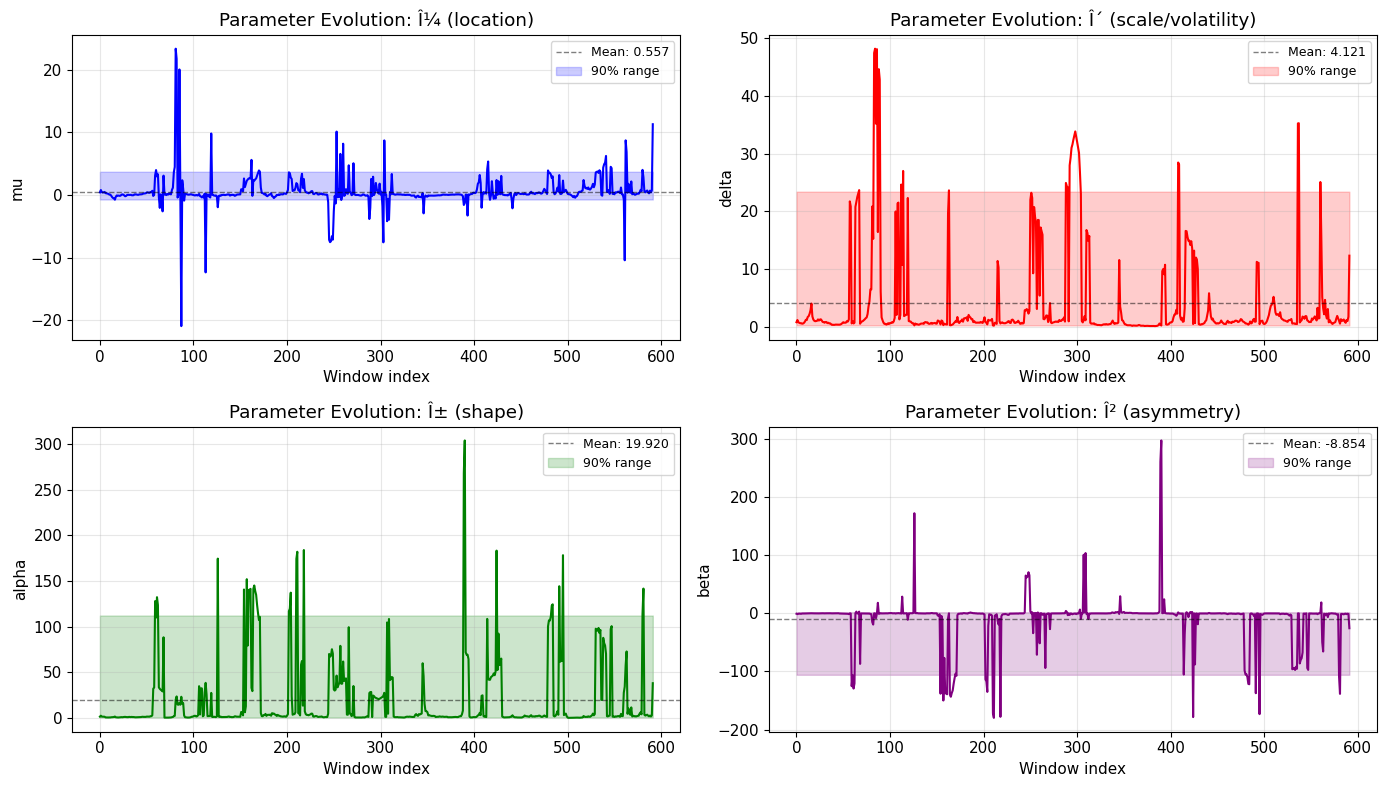

In [7]:
# Visualize parameter evolution
param_df = model.param_history

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

params_to_plot = ['mu', 'delta', 'alpha', 'beta']
colors = ['blue', 'red', 'green', 'purple']
titles = ['μ (location)', 'δ (scale/volatility)', 'α (shape)', 'β (asymmetry)']

for ax, param, color, title in zip(axes.flat, params_to_plot, colors, titles):
    values = param_df[param].values
    ax.plot(values, color=color, lw=1.5)
    ax.axhline(np.mean(values), color='black', ls='--', lw=1, alpha=0.5, label=f'Mean: {np.mean(values):.3f}')
    ax.fill_between(range(len(values)), 
                    np.percentile(values, 5), np.percentile(values, 95),
                    alpha=0.2, color=color, label='90% range')
    ax.set_xlabel('Window index')
    ax.set_ylabel(param)
    ax.set_title(f'Parameter Evolution: {title}')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_parameter_evolution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## 4. Projection: Forecast Parameters with Uncertainty

The `project()` method simulates future parameter paths using the fitted dynamics models.

In [8]:
# Project parameters forward
projection = model.project(horizon=30, n_paths=1000)

print('=' * 60)
print('PARAMETER PROJECTION')
print('=' * 60)
print(f'\nHorizon: {projection.horizon} days')
print(f'Monte Carlo paths: {projection.n_paths}')
print(f'\nProjected parameters: {list(projection.param_paths.keys())}')

# Show projections at different horizons
for t in [5, 15, 30]:
    print(f'\nAt t={t}:')
    means = projection.mean(t=t)
    q05 = projection.quantile(0.05, t=t)
    q95 = projection.quantile(0.95, t=t)
    print(f'  delta: {means["delta"]:.4f} [{q05["delta"]:.4f}, {q95["delta"]:.4f}]')

PARAMETER PROJECTION

Horizon: 30 days
Monte Carlo paths: 1000

Projected parameters: ['mu', 'delta', 'alpha', 'beta', 'mu_drift', 'delta_growth']

At t=5:
  delta: 3.5649 [-9.7419, 16.0624]

At t=15:
  delta: 4.1989 [-9.1754, 17.8236]

At t=30:
  delta: 3.9435 [-9.9800, 17.1774]


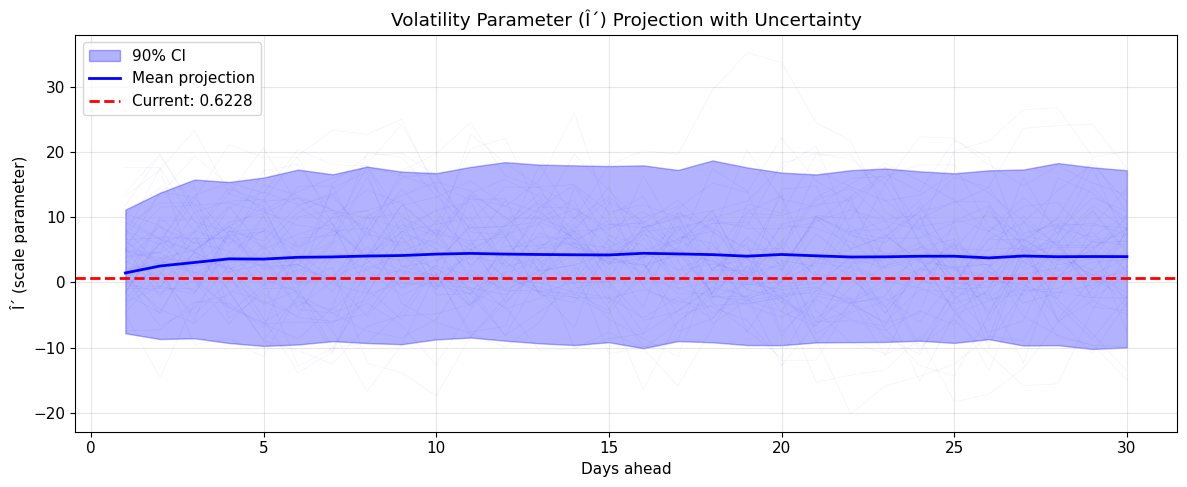

In [9]:
# Visualize parameter projections
fig, ax = plt.subplots(figsize=(12, 5))

# Plot delta projection paths
delta_paths = projection.param_paths['delta']
time_axis = np.arange(1, projection.horizon + 1)

# Plot some sample paths
for i in range(min(50, delta_paths.shape[0])):
    ax.plot(time_axis, delta_paths[i, :], 'b-', alpha=0.05, lw=0.5)

# Plot confidence bands
mean_path = np.mean(delta_paths, axis=0)
q05_path = np.percentile(delta_paths, 5, axis=0)
q95_path = np.percentile(delta_paths, 95, axis=0)

ax.fill_between(time_axis, q05_path, q95_path, alpha=0.3, color='blue', label='90% CI')
ax.plot(time_axis, mean_path, 'b-', lw=2, label='Mean projection')

# Mark current value
ax.axhline(model.current_params.delta, color='red', ls='--', lw=2, label=f'Current: {model.current_params.delta:.4f}')

ax.set_xlabel('Days ahead')
ax.set_ylabel('δ (scale parameter)')
ax.set_title('Volatility Parameter (δ) Projection with Uncertainty')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_projection.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## 5. Predictive Distribution & Decision Metrics

The `predictive()` method integrates over parameter uncertainty to get the full predictive distribution of returns.

The `decision()` method computes VaR, CVaR, and Kelly fraction **with confidence intervals**.

In [10]:
# Get decision metrics at different horizons
print('=' * 70)
print('DECISION METRICS WITH CONFIDENCE INTERVALS')
print('=' * 70)
print(f'{"Horizon":>8} {"VaR(95%)":>20} {"CVaR(95%)":>20} {"P(profit)":>12}')
print('-' * 70)

for t in [1, 5, 10, 20]:
    decision = model.decision(t=t, alpha=0.05, n_samples=5000, n_paths=500)
    
    var_str = f'{decision.var.value:.2f}% [{decision.var.confidence_interval[0]:.2f}, {decision.var.confidence_interval[1]:.2f}]'
    cvar_str = f'{decision.cvar.value:.2f}% [{decision.cvar.confidence_interval[0]:.2f}, {decision.cvar.confidence_interval[1]:.2f}]'
    prob_str = f'{decision.prob_profit.value:.1%}'
    
    print(f'{t:>8}d {var_str:>20} {cvar_str:>20} {prob_str:>12}')

DECISION METRICS WITH CONFIDENCE INTERVALS
 Horizon             VaR(95%)            CVaR(95%)    P(profit)
----------------------------------------------------------------------


       1d   4.19% [3.76, 4.74]  9.45% [8.18, 10.79]        64.8%


       5d   4.52% [3.91, 5.04] 17.32% [13.76, 21.05]        64.3%


      10d   4.94% [4.46, 5.43] 17.37% [13.50, 22.23]        64.3%


      20d   4.59% [4.16, 5.12] 15.38% [12.98, 17.98]        63.6%


In [11]:
# Detailed decision summary at t=5
decision = model.decision(t=5, alpha=0.05, n_samples=10000, n_paths=1000)

print('\n' + '=' * 60)
print(f'DETAILED DECISION SUMMARY (t=5 days, α=0.05)')
print('=' * 60)

print(f'\nValue at Risk (95%):')
print(f'  Point estimate: {decision.var.value:.4f}%')
print(f'  90% CI: [{decision.var.confidence_interval[0]:.4f}, {decision.var.confidence_interval[1]:.4f}]')

print(f'\nConditional VaR (95%):')
print(f'  Point estimate: {decision.cvar.value:.4f}%')
print(f'  90% CI: [{decision.cvar.confidence_interval[0]:.4f}, {decision.cvar.confidence_interval[1]:.4f}]')

print(f'\nKelly Fraction:')
print(f'  Point estimate: {decision.kelly.value:.4f}')
print(f'  90% CI: [{decision.kelly.confidence_interval[0]:.4f}, {decision.kelly.confidence_interval[1]:.4f}]')

print(f'\nOther Metrics:')
print(f'  P(profit): {decision.prob_profit.value:.2%}')
print(f'  Expected return: {decision.expected_return:.4f}%')
print(f'  Volatility: {decision.volatility:.4f}%')


DETAILED DECISION SUMMARY (t=5 days, α=0.05)

Value at Risk (95%):
  Point estimate: 4.9209%
  90% CI: [4.5040, 5.1495]

Conditional VaR (95%):
  Point estimate: 14.9550%
  90% CI: [13.2542, 16.8090]

Kelly Fraction:
  Point estimate: -0.0058
  90% CI: [-0.0081, -0.0029]

Other Metrics:
  P(profit): 64.94%
  Expected return: -0.1741%
  Volatility: 5.4722%


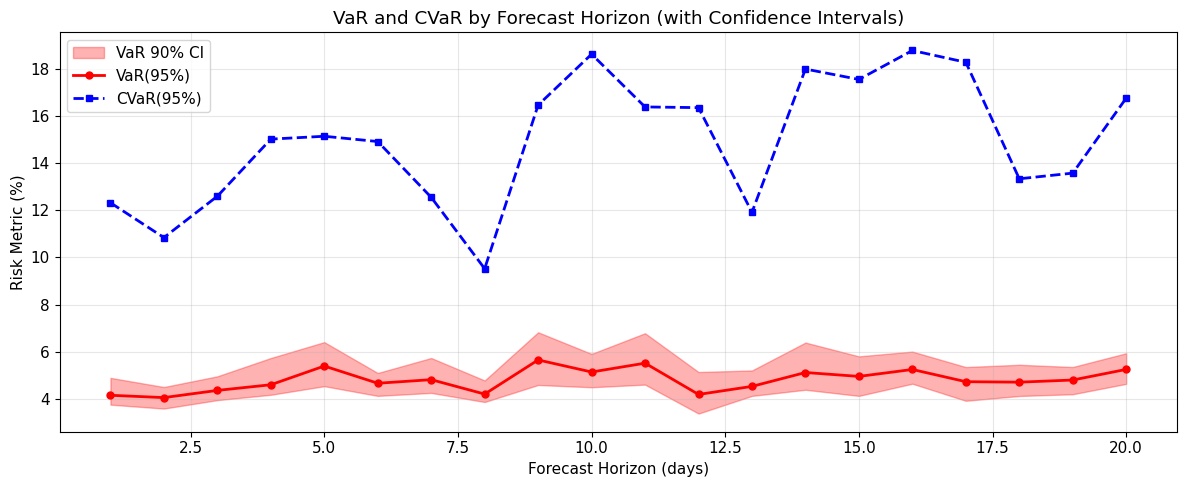

In [12]:
# Visualize VaR/CVaR over horizons
horizons = list(range(1, 21))
var_values = []
var_lower = []
var_upper = []
cvar_values = []

for t in horizons:
    d = model.decision(t=t, alpha=0.05, n_samples=3000, n_paths=300)
    var_values.append(d.var.value)
    var_lower.append(d.var.confidence_interval[0])
    var_upper.append(d.var.confidence_interval[1])
    cvar_values.append(d.cvar.value)

fig, ax = plt.subplots(figsize=(12, 5))

ax.fill_between(horizons, var_lower, var_upper, alpha=0.3, color='red', label='VaR 90% CI')
ax.plot(horizons, var_values, 'r-', lw=2, marker='o', markersize=5, label='VaR(95%)')
ax.plot(horizons, cvar_values, 'b--', lw=2, marker='s', markersize=5, label='CVaR(95%)')

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Risk Metric (%)')
ax.set_title('VaR and CVaR by Forecast Horizon (with Confidence Intervals)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_risk_metrics.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## 6. Backtest: Validate with Statistical Tests

The `Backtest` class runs rolling VaR forecasts and validates them using:
- **Kupiec test**: Is the exceedance rate correct? (unconditional coverage)
- **Christoffersen test**: Are exceedances independent? (no clustering)

In [13]:
# Run backtest on test data
bt_nig = tpdf.Backtest(
    distribution='nig',
    lookback=60,
    alpha=0.05,
    step=1
)

# Also test Normal for comparison
bt_normal = tpdf.Backtest(
    distribution='normal',
    lookback=60,
    alpha=0.05,
    step=1
)

print('Running VaR backtests...')
result_nig = bt_nig.run(test_returns)
result_normal = bt_normal.run(test_returns)

print('\n' + '=' * 70)
print('BACKTEST RESULTS')
print('=' * 70)
print(f'{"":15} {"Normal":>20} {"NIG":>20}')
print('-' * 70)
print(f'{"Exceedances":15} {result_normal.n_exceedances:>17} ({result_normal.exceedance_rate:.1%}) {result_nig.n_exceedances:>17} ({result_nig.exceedance_rate:.1%})')
print(f'{"Expected":15} {"5.0%":>20} {"5.0%":>20}')
print(f'{"Kupiec p-val":15} {result_normal.kupiec_pvalue:>20.4f} {result_nig.kupiec_pvalue:>20.4f}')
print(f'{"Christ. p-val":15} {result_normal.christoffersen_pvalue:>20.4f} {result_nig.christoffersen_pvalue:>20.4f}')
print(f'{"Status":15} {result_normal.status:>20} {result_nig.status:>20}')
print('-' * 70)
print('\nInterpretation:')
print('  - Kupiec test: p > 0.05 means exceedance rate is acceptable')
print('  - Christoffersen test: p > 0.05 means no significant clustering')
print('  - PASS means both tests passed')

Running VaR backtests...



BACKTEST RESULTS
                              Normal                  NIG
----------------------------------------------------------------------
Exceedances                    44 (6.3%)                45 (6.5%)
Expected                        5.0%                 5.0%
Kupiec p-val                  0.1214               0.0873
Christ. p-val                 0.1971               0.5183
Status                          PASS                 PASS
----------------------------------------------------------------------

Interpretation:
  - Kupiec test: p > 0.05 means exceedance rate is acceptable
  - Christoffersen test: p > 0.05 means no significant clustering
  - PASS means both tests passed


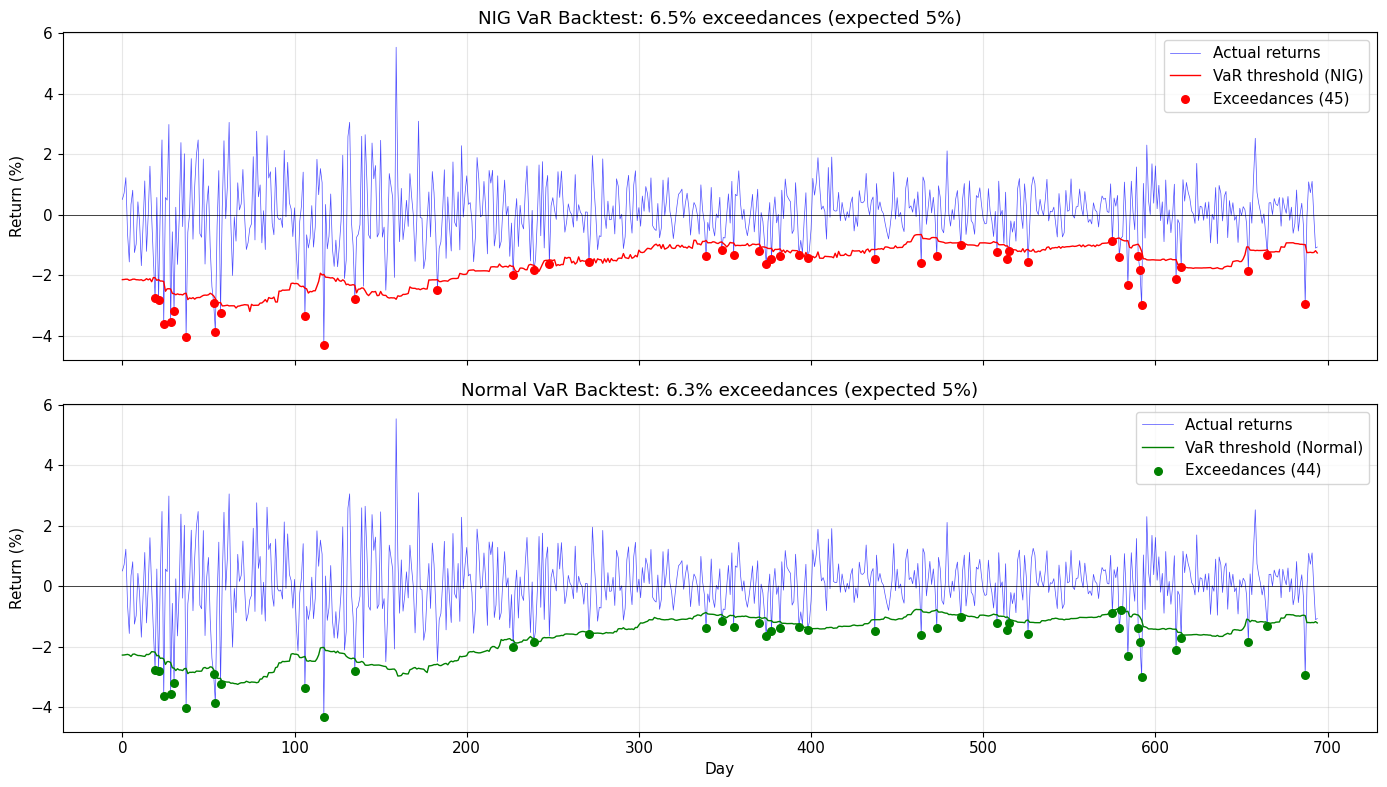

In [14]:
# Visualize backtest results
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Panel 1: Returns with VaR threshold (NIG)
ax = axes[0]
n_forecasts = result_nig.n_total
x = np.arange(n_forecasts)

ax.plot(x, result_nig.actual_returns, 'b-', lw=0.5, alpha=0.7, label='Actual returns')
ax.plot(x, -result_nig.var_forecasts, 'r-', lw=1, label='VaR threshold (NIG)')

# Mark exceedances
exc_idx = np.where(result_nig.exceedances)[0]
ax.scatter(exc_idx, result_nig.actual_returns[exc_idx], c='red', s=30, zorder=5, label=f'Exceedances ({len(exc_idx)})')

ax.axhline(0, color='black', ls='-', lw=0.5)
ax.set_ylabel('Return (%)')
ax.set_title(f'NIG VaR Backtest: {result_nig.exceedance_rate:.1%} exceedances (expected 5%)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 2: Same for Normal
ax = axes[1]
ax.plot(x, result_normal.actual_returns, 'b-', lw=0.5, alpha=0.7, label='Actual returns')
ax.plot(x, -result_normal.var_forecasts, 'g-', lw=1, label='VaR threshold (Normal)')

exc_idx_n = np.where(result_normal.exceedances)[0]
ax.scatter(exc_idx_n, result_normal.actual_returns[exc_idx_n], c='green', s=30, zorder=5, label=f'Exceedances ({len(exc_idx_n)})')

ax.axhline(0, color='black', ls='-', lw=0.5)
ax.set_xlabel('Day')
ax.set_ylabel('Return (%)')
ax.set_title(f'Normal VaR Backtest: {result_normal.exceedance_rate:.1%} exceedances (expected 5%)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_backtest.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## 7. Bonus: Stand-alone *_with_ci Functions

V2 also provides stand-alone functions that return `RiskMetric` objects with confidence intervals.

In [15]:
# Use stand-alone functions with CI
nig = tpdf.NIG()
params = tpdf.fit_nig(train_returns)

print('=' * 60)
print('STAND-ALONE FUNCTIONS WITH CONFIDENCE INTERVALS')
print('=' * 60)

# VaR with CI
var_result = tpdf.var_with_ci(nig, params, alpha=0.05)
print(f'\nVaR(95%) with CI:')
print(f'  Value: {var_result.value:.4f}%')
print(f'  CI: [{var_result.confidence_interval[0]:.4f}, {var_result.confidence_interval[1]:.4f}]')

# CVaR with CI
rng = np.random.default_rng(42)
cvar_result = tpdf.cvar_with_ci(nig, params, alpha=0.05, rng=rng)
print(f'\nCVaR(95%) with CI:')
print(f'  Value: {cvar_result.value:.4f}%')
print(f'  CI: [{cvar_result.confidence_interval[0]:.4f}, {cvar_result.confidence_interval[1]:.4f}]')

# Kelly with CI
kelly_result = tpdf.kelly_with_ci(nig, params, rng=rng)
print(f'\nKelly Fraction with CI:')
print(f'  Value: {kelly_result.value:.4f}')
print(f'  CI: [{kelly_result.confidence_interval[0]:.4f}, {kelly_result.confidence_interval[1]:.4f}]')

# These RiskMetric objects also convert to float seamlessly
print(f'\nRiskMetric converts to float: {float(var_result):.4f}')

STAND-ALONE FUNCTIONS WITH CONFIDENCE INTERVALS



VaR(95%) with CI:
  Value: 1.6587%
  CI: [1.6401, 1.6754]



CVaR(95%) with CI:
  Value: 2.4389%
  CI: [2.4142, 2.4651]



Kelly Fraction with CI:
  Value: 0.0481
  CI: [0.0430, 0.0530]

RiskMetric converts to float: 1.6587


---

## Summary

### V2 API Components Used

| Component | Purpose |
|-----------|--------|
| `tpdf.discover()` | Cross-validated distribution comparison |
| `DiscoveryResult` | Scores, confidence, p-values |
| `ParameterTracker` | Rolling window parameter estimation |
| `EMA`, `MeanReverting`, `Constant` | Weighting and dynamics models |
| `TemporalModel` | Combines tracking, weighting, dynamics |
| `Projection` | Monte Carlo parameter forecasts |
| `PredictiveDistribution` | Integrates over parameter uncertainty |
| `DecisionSummary` | VaR, CVaR, Kelly with CIs |
| `RiskMetric` | Point estimate + confidence interval |
| `Backtest` | Rolling VaR validation |
| `kupiec_test`, `christoffersen_test` | Statistical validation |
| `var_with_ci`, `cvar_with_ci`, `kelly_with_ci` | Stand-alone functions |

### Key Insight

**Point predictions give you a number. Distribution predictions give you:**
- The number (mean/median)
- How confident you should be (standard error, CI)
- Worst-case scenarios (VaR, CVaR)
- Optimal position sizing (Kelly)
- Full probabilistic queries (P(X > threshold))

All of this comes **for free** once you predict distribution parameters instead of Y directly.

In [16]:
print('\n' + '=' * 60)
print('SHOWCASE COMPLETE')
print('=' * 60)
print('\nFiles generated:')
print('  - v2_discovery.png')
print('  - v2_parameter_evolution.png')
print('  - v2_projection.png')
print('  - v2_risk_metrics.png')
print('  - v2_backtest.png')


SHOWCASE COMPLETE

Files generated:
  - v2_discovery.png
  - v2_parameter_evolution.png
  - v2_projection.png
  - v2_risk_metrics.png
  - v2_backtest.png
